In [1]:
## Enable horizontal scroll in shell outputs (optional)
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

## To run this notebook:
1. <font color='red'>In Windows, follow <a href="https://gist.github.com/vicente-gonzalez-ruiz/afa958f0829d935858e56f8afe12512b">this Gist</a>.</font>
2. <font color='red'>In Linux (and OSX), follow follow <a href="https://gist.github.com/vicente-gonzalez-ruiz/ad8c70840415301c628e839eaa4b4a2d">this Gist</a>.</font>

# [InterCom](https://github.com/Tecnologias-multimedia/intercom): a [Real-Time](https://en.wikipedia.org/wiki/Real-time) [Digital Audio](https://en.wikipedia.org/wiki/Digital_audio) [Full-Duplex](https://en.wikipedia.org/wiki/Duplex_(telecommunications)#FULL-DUPLEX) [Transmitter/Receiver](https://en.wikipedia.org/w/index.php?title=Data_transmission&redirect=no)

In [2]:
!pip install -r ../requirements.txt

  Obtaining dependency information for argcomplete from https://files.pythonhosted.org/packages/73/44/42ff5ee76b3881bebe226614c658df9423fe8ddd3d7967e6850b008f4899/argcomplete-3.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for PyWavelets from https://files.pythonhosted.org/packages/37/cc/3aa33e99e1031227749711177d916ca3a4a1fa1b63d830776bc49991f7ff/pywavelets-1.5.0-cp312-cp312-win_amd64.whl.metadata
     ---------------------------------------- 0.0/199.7 kB ? eta -:--:--
     ----------- --------------------------- 61.4/199.7 kB 1.6 MB/s eta 0:00:01
     -------------------------------------- 199.7/199.7 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     ------------------- -------------------- 0.5/1.0 MB 15.5 MB/s eta 0:00:01
     ---------------------------------------- 1.0/1.0 MB 12.8 MB/s eta 0:00:00
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/2e/51/c77a14869b7eb9d6


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Contents

1. What is InterCom?
2. Hiding the jitter.
3. Compression with DEFLATE.
4. A simple bit-rate control through quantization.
5. Removing intra-frame redundancy.
6. Removing intra-channel redundancy.
7. Perceptual coding.
8. Next improvements.

## 1. What is InterCom?

* InterCom is a [full-duplex](https://en.wikipedia.org/wiki/Duplex_(telecommunications)#FULL-DUPLEX) real-time [intercommunicator](https://en.wikipedia.org/wiki/Intercom) for digital ([PCM](https://en.wikipedia.org/wiki/Pulse-code_modulation)) audio, that uses [the Internet](https://en.wikipedia.org/wiki/Internet).

### A [minimal](https://tecnologias-multimedia.github.io/study_guide/minimal/) implementation

* In [`minimal.py`](https://github.com/Tecnologias-multimedia/InterCom/blob/master/src/minimal.py), the sender (of audio) splits a sequence of [frames](https://python-sounddevice.readthedocs.io/en/0.3.12/api.html) (two [stereo](https://en.wikipedia.org/wiki/Stereophonic_sound) [samples](https://en.wikipedia.org/wiki/Sampling_(signal_processing))) in chunks (of constant length) and each one is transmitted in an [UDP](https://en.wikipedia.org/wiki/User_Datagram_Protocol) packet. At the receiver, the sequence of frames is reconstructed and played.

        +-------------------------+                    +-------------------------+
        | Host A                  |                    | Host B                  |
        |  +----------+           |                    |           +----------+  |
        |  | InterCom |    +------+    +----------+    +------+    | InterCom |  |
        |  | process  |<-->| 4444 |<-->| Internet |<-->| 4444 |<-->| process  |  |
        |  +----------+    +------+    +----------+    +------+    +----------+  |
        |                         |                    |                         |
        +-------------------------+                    +-------------------------+

* By default, InterCom sends the audio from the port 4444 to the port 4444 in the `localhost` (Host A == Host B == `localhost`), resulting in that we play the audio that we have just previously recorded, and obviously we don't need any interconexion network. If you want to analyze the sent (and received InterCom's chunks), in a terminal run (only Linux):

    `sudo tcpdump -i lo | grep 4444`

<p style="padding: 10px; border: 2px solid blue;"><font color='red'>Before running the next cell, please, check that the mic(rophone) and the speakers gains are not too high!</font><p>

In [1]:
# Run this cell if you have a mic
!python ../src/minimal.py --show_stats -t 6

(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100

InterCom parameters:

Namespace(input_device=None, output_device=None, list_devices=False, frames_per_second=44100, frames_per_chunk=1024, listening_port=4444, destination_address='localhost', destination_port=4444, filename=None, reading_time=6, show_stats=True, show_samples=False)

Using device:

   0 HDA NVidia: HDMI 0 (hw:0,3), ALSA (0 in, 8 out)
   1 HDA NVidia: HDMI 1 (hw:0,7), ALSA (0 in, 8 out)
   2 HDA NVidia: HDMI 2 (hw:0,8), ALSA (0 in, 8 out)
   3 HDA NVidia: HDMI 3 (hw:0,9), ALSA (0 in, 8 out)
   4 sof-hda-dsp: - (hw:1,0), ALSA (2 in, 2 out)
   5 sof-hda-dsp: - (hw:1,3), ALSA (0 in, 2 

In [2]:
# Run this cell if the mic does not work
!python ../src/minimal.py --show_stats -t 5 -f ../data/AviadorDro_LaZonaFantasma.oga

(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100

InterCom parameters:

Namespace(input_device=None, output_device=None, list_devices=False, frames_per_second=44100, frames_per_chunk=1024, listening_port=4444, destination_address='localhost', destination_port=4444, filename='../data/AviadorDro_LaZonaFantasma.oga', reading_time=5, show_stats=True, show_samples=False)

Using device:

   0 HDA NVidia: HDMI 0 (hw:0,3), ALSA (0 in, 8 out)
   1 HDA NVidia: HDMI 1 (hw:0,7), ALSA (0 in, 8 out)
   2 HDA NVidia: HDMI 2 (hw:0,8), ALSA (0 in, 8 out)
   3 HDA NVidia: HDMI 3 (hw:0,9), ALSA (

In [4]:
# Run this cell if you are using a virtual machine or very old real one, and the previous examples do not work
!python ../src/minimal.py --show_stats -t 5 -s 8000 -f ../data/AviadorDro_LaZonaFantasma_8000Hz.oga --frames_per_chunk 256

(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.032 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma_8000Hz.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 31.25
(INFO) minimal: frames_per_cycle = 8000.0

InterCom parameters:

Namespace(input_device=None, output_device=None, list_devices=False, frames_per_second=8000.0, frames_per_chunk=256, listening_port=4444, destination_address='localhost', destination_port=4444, filename='../data/AviadorDro_LaZonaFantasma_8000Hz.oga', reading_time=5, show_stats=True, show_samples=False)

Using device:

   0 HDA NVidia: HDMI 0 (hw:0,3), ALSA (0 in, 2 out)
   1 HDA NVidia: HDMI 1 (hw:0,7), ALSA (0 in, 8 out)
   2 HDA NVidia: HDMI 2 (hw:0,8), ALSA (0 in, 8 out)
   3 HDA NVidia: HDMI 3 (hw:0,9), ALSA (0 in, 

## 2. [Hiding](https://tecnologias-multimedia.github.io/study_guide/latency/) the [packet jitter](https://en.wikipedia.org/wiki/Packet_delay_variation)

* The communication network (Internet) usually delays a random amount of time the transmission of the chunks, i.e., generates a jitter (packet delay-variation during the transmission of a sequence of packets).

* This jitter can be hiden through the [buffering](https://tecnologias-multimedia.github.io/contents/latency/) (delaying) of the received chunks, before playing them (left: the problem, right: a solution):

![With and without buffering](https://tecnologias-multimedia.github.io/contents/latency/graphics/timelines.svg)
<!-- ![With and without buffering](/home/vruiz/timelines.svg)
![With and without buffering](./tmp/timelines.svg)
![With and without buffering](../../../timelines.svg) -->

* The buffer size depends on the user's preferences (the larger the buffer, the lower the number of (too much delayed) lost chunks).

### Measuring the jitter in my host

Using `ping`.

![RTT and ping](https://tecnologias-multimedia.github.io/contents/latency/graphics/ping_timeline.svg)
<center>$t_t =$ Transmission Time, $t_p =$ Propagation Time</center>

* The `min/avg/max/mdev` represents the minimum [RTT](https://en.wikipedia.org/wiki/Round-trip_delay) / average RTT / maximum RTT / standard deviation of the RTT.
* Latency is the RTT divided by 2.
* Usually, the jitter that we want to hide is the `mdev`/2.
* Unfortunately, `localhost` is too good to simulate typical transmissions scenarios :-/

#### Linux/OSX:

In [5]:
!ping -c 3 localhost

PING localhost (127.0.0.1) 56(84) bytes of data.
64 bytes from localhost (127.0.0.1): icmp_seq=1 ttl=64 time=0.014 ms
64 bytes from localhost (127.0.0.1): icmp_seq=2 ttl=64 time=0.054 ms
64 bytes from localhost (127.0.0.1): icmp_seq=3 ttl=64 time=0.018 ms

--- localhost ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2052ms
rtt min/avg/max/mdev = 0.014/0.028/0.054/0.018 ms


#### Windows:

In [3]:
!ping -n 3 localhost


Haciendo ping a DESKTOP-QLGL9QA [::1] con 32 bytes de datos:
Respuesta desde ::1: tiempo<1m 
Respuesta desde ::1: tiempo<1m 
Respuesta desde ::1: tiempo<1m 

Estad¡sticas de ping para ::1:
    Paquetes: enviados = 3, recibidos = 3, perdidos = 0
    (0% perdidos),
Tiempos aproximados de ida y vuelta en milisegundos:
    M¡nimo = 0ms, M ximo = 0ms, Media = 0ms


### How is the jitter in the Internet?
Pinging the Google domain name server 8.8.8.8.

#### Linux/OSX:

In [3]:
!ping -c 3 8.8.8.8

PING 8.8.8.8 (8.8.8.8) 56(84) bytes of data.
64 bytes from 8.8.8.8: icmp_seq=1 ttl=118 time=12.1 ms
64 bytes from 8.8.8.8: icmp_seq=2 ttl=118 time=12.0 ms
64 bytes from 8.8.8.8: icmp_seq=3 ttl=118 time=11.7 ms

--- 8.8.8.8 ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2003ms
rtt min/avg/max/mdev = 11.680/11.911/12.068/0.166 ms


#### Windows:

In [4]:
!ping -n 3 8.8.8.8


Haciendo ping a 8.8.8.8 con 32 bytes de datos:
Respuesta desde 8.8.8.8: bytes=32 tiempo=11ms TTL=118
Respuesta desde 8.8.8.8: bytes=32 tiempo=12ms TTL=118
Respuesta desde 8.8.8.8: bytes=32 tiempo=11ms TTL=118

Estad¡sticas de ping para 8.8.8.8:
    Paquetes: enviados = 3, recibidos = 3, perdidos = 0
    (0% perdidos),
Tiempos aproximados de ida y vuelta en milisegundos:
    M¡nimo = 11ms, M ximo = 12ms, Media = 11ms


* OK, it's clear that if we want to simulate a real scenario using `localhost` then we need to add some random latency.

### Increase latency and jitter for the `localhost` link (only Linux)
* Using [`tc`](https://man7.org/linux/man-pages/man8/tc.8.html) (Traffic Control).
* Example with:
    * Average latency = 20 ms (average RTT = 40 ms).
    * Average `mdev` = 5 ms.
    * [Perarson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between delays = 0.25 (1.0 means total [correlation](https://en.wikipedia.org/wiki/Correlation) between consecutive transmissions, 0.0 implies no correlation).
    * Statistical distribution of the RTTs = [normal](https://en.wikipedia.org/wiki/Normal_distribution).
* We see the effects in `ping`.

<p style="padding: 10px; border: 2px solid blue;"><font color='red'>Please, before running the next cell, be sure that sudo does NOT request a password (open a terminal and run, for example, `sudo ls`). If a password is required, add the line `your_username ALL=(ALL) NOPASSWD: ALL` at the end of the `/etc/sudoers` file.</font><p>

<p style="padding: 10px; border: 2px solid blue;"><font color='red'>You must be aware that the modification of the latency/throughput of the `localhost` adapter affect also to the refresing time of this notebook! Please, be patient.</font><p>

In [4]:
avg_latency = 300
mean_deviation = 50
correlation = 25
distribution = "normal"

# Activate tc rules
!tc qdisc show dev lo
!sudo tc qdisc add dev lo root handle 1: netem delay {avg_latency}ms {mean_deviation}ms {correlation}% distribution {distribution}

# Show rules    
!tc qdisc show dev lo

# See the effect
!ping -c 3 localhost

# Remove rules
!sudo tc qdisc del dev lo root
!tc qdisc show dev lo

# See the effect
!ping -c 3 localhost

qdisc noqueue 0: root refcnt 2 
qdisc netem 1: root refcnt 2 limit 1000 delay 300ms  50ms 25%
PING localhost (127.0.0.1) 56(84) bytes of data.
64 bytes from localhost (127.0.0.1): icmp_seq=1 ttl=64 time=677 ms
64 bytes from localhost (127.0.0.1): icmp_seq=2 ttl=64 time=391 ms
64 bytes from localhost (127.0.0.1): icmp_seq=3 ttl=64 time=508 ms

--- localhost ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2000ms
rtt min/avg/max/mdev = 390.863/525.225/676.756/117.345 ms
qdisc noqueue 0: root refcnt 2 
PING localhost (127.0.0.1) 56(84) bytes of data.
64 bytes from localhost (127.0.0.1): icmp_seq=1 ttl=64 time=0.026 ms
64 bytes from localhost (127.0.0.1): icmp_seq=2 ttl=64 time=0.049 ms
64 bytes from localhost (127.0.0.1): icmp_seq=3 ttl=64 time=0.059 ms

--- localhost ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2034ms
rtt min/avg/max/mdev = 0.026/0.044/0.059/0.013 ms


### Let's listen again to minimal
... using a high jitter.

In [5]:
# Real machine

avg_latency = 300
mean_deviation = 50
correlation = 25
distribution = "normal"

!tc qdisc show dev lo
!sudo tc qdisc add dev lo root handle 1: netem delay {avg_latency}ms {mean_deviation}ms {correlation}% distribution {distribution}
!tc qdisc show dev lo

#!python ../src/minimal.py --show_stats -t 5  # If you want to listen to yourself
!python ../src/minimal.py --show_stats -t 5 -f ../data/AviadorDro_LaZonaFantasma.oga

!sudo tc qdisc del dev lo root
!tc qdisc show dev lo

qdisc noqueue 0: root refcnt 2 
qdisc netem 1: root refcnt 2 limit 1000 delay 300ms  50ms 25%
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100

InterCom parameters:

Namespace(input_device=None, output_device=None, list_devices=False, frames_per_second=44100, frames_per_chunk=1024, listening_port=4444, destination_address='localhost', destination_port=4444, filename='../data/AviadorDro_LaZonaFantasma.oga', reading_time=5, show_stats=True, show_samples=False)

Using device:

   0 HDA NVidia: HDMI 0 (hw:0,3), ALSA (0 in, 8 out)
   1 HDA NVidia: HDMI 1 (hw:0,7), ALSA (0 in, 8 out)

In [ ]:
# Virtual machine

avg_latency = 300
mean_deviation = 50
correlation = 25
distribution = "normal"

!tc qdisc show dev lo
!sudo tc qdisc add dev lo root handle 1: netem delay {avg_latency}ms {mean_deviation}ms {correlation}% distribution {distribution}
!tc qdisc show dev lo

#!python ../src/minimal.py --show_stats -t 5
#!python ../src/minimal.py --show_stats -t 5 --frames_per_second 8000 #--frames_per_chunk 256
#!python ../src/minimal.py --show_stats -t 5 -f ../data/AviadorDro_LaZonaFantasma.oga #--frames_per_second 8000
!python ../src/minimal.py --show_stats -t 5 -s 8000 -f ../data/AviadorDro_LaZonaFantasma_8000Hz.oga --frames_per_chunk 256

!sudo tc qdisc del dev lo root
!tc qdisc show dev lo

### Quite bad :-/ The chunks are not arriving with a constant cadence to the receiver

### Let's hidden the jitter
* The default buffering time in InterCom is 150 ms (see `buffer.py -h`).

In [7]:
avg_latency = 300
mean_deviation = 50
correlation = 25
distribution = "normal"

!tc qdisc show dev lo
!sudo tc qdisc add dev lo root handle 1: netem delay {avg_latency}ms {mean_deviation}ms {correlation}% distribution {distribution}
!tc qdisc show dev lo

!ping -c 3 localhost

#!python ../src/buffer.py --show_stats -t 5
!python ../src/buffer.py --show_stats -B 300 -t 5 -f ../data/AviadorDro_LaZonaFantasma.oga

# Remove rules
!sudo tc qdisc del dev lo root
!tc qdisc show dev lo

qdisc noqueue 0: root refcnt 2 
qdisc netem 1: root refcnt 2 limit 1000 delay 300ms  50ms 25%
PING localhost (127.0.0.1) 56(84) bytes of data.
64 bytes from localhost (127.0.0.1): icmp_seq=1 ttl=64 time=540 ms
64 bytes from localhost (127.0.0.1): icmp_seq=2 ttl=64 time=596 ms
64 bytes from localhost (127.0.0.1): icmp_seq=3 ttl=64 time=580 ms

--- localhost ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2002ms
rtt min/avg/max/mdev = 540.264/572.241/596.160/23.520 ms
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, impleme

### Much better!

## 3. [Compression with DEFLATE](https://tecnologias-multimedia.github.io/study_guide/BR_control/#x1-40001.2)

### Estimation of the [throughput](https://en.wikipedia.org/wiki/Throughput) of the `localhost` link (only Linux)

* Notice that the following technique depends heavily on the packet size, that using `ping` is limited to 64 KB (including the IP header). For this reason, our results will be only approximated :-/

In [8]:
!ping -c 1 -s 65507 localhost > /tmp/1
!cat /tmp/1
!grep rtt /tmp/1 | cut -f 5 -d "/" > /tmp/2
f = open("/tmp/2")
time = f.read()
print("transmission time =", time)
print("GBPS =", 65507*8/float(time)/2/1000/1000)

PING localhost (127.0.0.1) 65507(65535) bytes of data.
65515 bytes from localhost (127.0.0.1): icmp_seq=1 ttl=64 time=0.024 ms

--- localhost ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 0.024/0.024/0.024/0.000 ms
transmission time = 0.024

GBPS = 10.917833333333334


* Too high! We need harder bandwidth conditions for testing InterCom, which without compression requires:

\begin{equation}
\frac{44100\frac{\text{frames}}{\text{second}}\times 2\frac{\text{samples}}{\text{frame}}\times 2\frac{\text{bytes}}{\text{sample}}\times 8\frac{\text{bits}}{\text{byte}}}{1000} = 1411.2 ~\text{KBPS} \approx 1.4~\text{MBPS}
\end{equation}

### Effect in `ping` of limiting the throughput (only Linux)
Using `tc`.

In [9]:
avg_latency = 10
mean_deviation = 10
correlation = 50
distribution = "normal"
throughput = 300 # KBPS

# Modify the latency and the throughput
!sudo tc qdisc add dev lo root handle 1: netem delay {avg_latency}ms {mean_deviation}ms {correlation}% distribution {distribution}
!sudo tc qdisc add dev lo parent 1:1 handle 10: tbf rate {throughput}kbit burst 1024kbit limit 1024kbit

# Measure throughput
!ping -c 1 -s 65507 localhost > /tmp/1
!cat /tmp/1
!grep rtt /tmp/1 | cut -f 5 -d "/" > /tmp/2
f = open("/tmp/2")
time = f.read()
print(time)

# Delete the rules
!sudo tc qdisc del dev lo parent 1:1 handle 10:
!sudo tc qdisc del dev lo root
!tc qdisc show dev lo

print("Throughput =", 65507*8/float(time)/2, "KBPS")

PING localhost (127.0.0.1) 65507(65535) bytes of data.
65515 bytes from localhost (127.0.0.1): icmp_seq=1 ttl=64 time=13.7 ms

--- localhost ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 13.711/13.711/13.711/0.000 ms
13.711

qdisc noqueue 0: root refcnt 2 
Throughput = 19110.786959375684 KBPS


* Well, the limit of the throughput for a burst transmission is not effective, but for a sequence of chunks yes.

### Let's see the effect of the throughput limit (only Linux)

In [10]:
avg_latency = 10
mean_deviation = 10
correlation = 50
distribution = "normal"
throughput = 300 # KBPS

!sudo tc qdisc add dev lo root handle 1: netem delay {avg_latency}ms {mean_deviation}ms {correlation}% distribution {distribution}
!sudo tc qdisc add dev lo parent 1:1 handle 10: tbf rate {throughput}kbit burst 64kbit limit 64kbit

!python ../src/buffer.py --show_stats -t 5 -f ../data/AviadorDro_LaZonaFantasma.oga

!sudo tc qdisc del dev lo parent 1:1 handle 10:
!sudo tc qdisc del dev lo root
!tc qdisc show dev lo

(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7
(INFO) buffer: Using "../data/AviadorDro_LaZonaFantasma.oga" as input

InterCom parameters:

Namespace(input_device=None, output_device=None, list_devices=False, frames_per_second=44100, frames_per_chunk=1024, listening_port=4444, destination_address='localhost', destination_port=4444, filename='../data/AviadorDro_LaZonaFantasma.oga', reading_time=5, sh

### So, depending on the link's thoughput and the bit-rate of the audio ...
... a subset of the chunks are not transmitted, because the link is congested :-/

### [DEFLATE](https://en.wikipedia.org/wiki/DEFLATE) can mitigate the problem

* The chunks can be compressed with [LZSS](https://en.wikipedia.org/wiki/Lempel-Ziv-Storer-Szymanski), that is based on [LZ77](https://github.com/vicente-gonzalez-ruiz/LZ77) and [Huffman Coding](https://vicente-gonzalez-ruiz.github.io/Huffman_coding/).

* We have choosen this text compressor codec because:
    1. It's fast.
    2. Works well when repeated "strings" are found at the input.
    3. Available in [The Standard Python Library](https://docs.python.org/3/library/) ([zlib](https://docs.python.org/3/library/zlib.html)).
    4. Generic (eats anything), and almost never expands.

In [11]:
avg_latency = 10
mean_deviation = 10
correlation = 50
distribution = "normal"
throughput = 300 # KBPS

!sudo tc qdisc add dev lo root handle 1: netem delay {avg_latency}ms {mean_deviation}ms {correlation}% distribution {distribution}
!sudo tc qdisc add dev lo parent 1:1 handle 10: tbf rate {throughput}kbit burst 64kbit limit 64kbit

!python ../src/DEFLATE_byteplanes2.py --show_stats -t 5 -f ../data/AviadorDro_LaZonaFantasma.oga

!sudo tc qdisc del dev lo parent 1:1 handle 10:
!sudo tc qdisc del dev lo root
!tc qdisc show dev lo

(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7
(INFO) buffer: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) DEFLATE_raw: Compress each raw chunk using DEFLATE.
(INFO) DEFLATE_byteplanes2: Compress the least significant byte planes of the chunks using DEFLATE. The channels are consecutive (serialized). 2 code-streams (one per byte-plane) are generated.

InterCom parameters:

Namespace

* Notice that still a part of chunks are still lost.

###  In general, DEFLATE is not enough :-/ ... We need to compress more!

## 4. A simple [bit-rate "control"](https://tecnologias-multimedia.github.io/study_guide/BR_control/#x1-60001.4) through [quantization](https://tecnologias-multimedia.github.io/study_guide/BR_control/#x1-50001.3) (and DEFLATE)

* Quantization removes the less relevant information (mainly [electronic noise](https://en.wikipedia.org/wiki/Noise_(electronics)) if the quantization step size is small) and helps to increase the [compression ratio](https://en.wikipedia.org/wiki/Compression_ratio).
* In lossy signal compression, [dead-zone quantizers](https://github.com/vicente-gonzalez-ruiz/quantization/blob/master/digital_quantization.ipynb) are commonly used because they tend to generate 0's that like to entropy compressors. We use the quantizer
\begin{equation}
  k = \text{sgn}(x) \max\left(0, \left\lfloor \frac{\left| x \right|}{\Delta} + \frac{1}{2}\right\rfloor\right),
\end{equation}
where $k$ is the quantization index, and $\Delta$ is the quantization step size. The dequantizer is defined by:
\begin{equation}
  y = \Delta k.
\end{equation}
* This class of quantizers can operate by bit-planes when $\Delta$ is a power of 2.

In [14]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import math
import numpy as np
import sounddevice as sd
from scipy import signal

In [15]:
def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int16)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

In [16]:
def plot(x, y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    ax.plot(x, y)
    plt.show(block=False)

In [17]:
x = np.linspace(-8, 8, 500) # Input samples
k2 = quantizer(x, quantization_step = 2)
y2 = dequantizer(k2, quantization_step = 2)
k3 = quantizer(x, quantization_step = 3)
y3 = dequantizer(k3, quantization_step = 3)

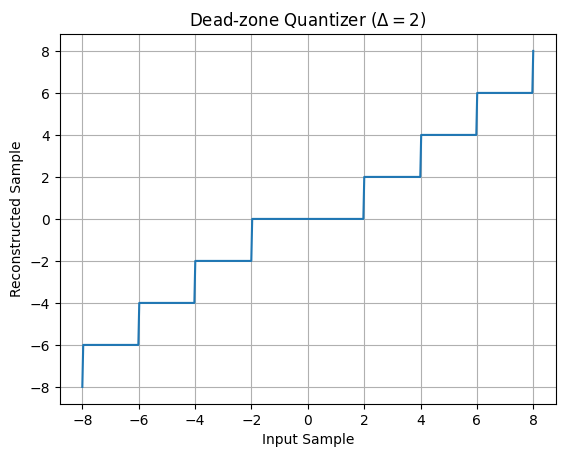

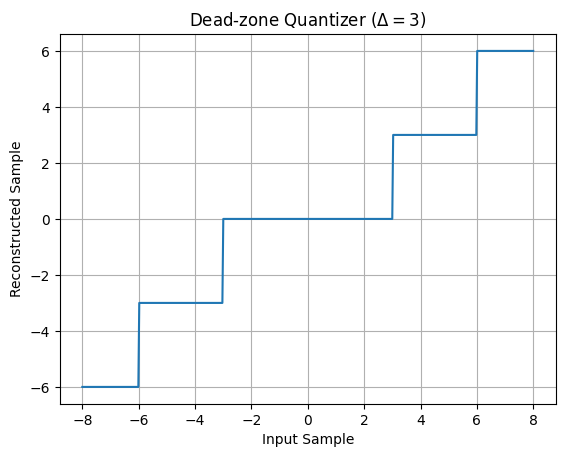

In [18]:
plot(x, y2, "Input Sample", "Reconstructed Sample", "Dead-zone Quantizer ($\Delta={}$)".format(2))
plot(x, y3, "Input Sample", "Reconstructed Sample", "Dead-zone Quantizer ($\Delta={}$)".format(3))

In [19]:
def q_deq(x, quantization_step):
    k = quantizer(x, quantization_step)
    y = dequantizer(k, quantization_step)
    return k, y

In [20]:
x = np.arange(start = -8, stop = 9, step = 1)
k, y = q_deq(x, quantization_step = 3)
print("    Original samples =", x)
print("Quantization indexes =", k)
print(" Dequantized samples =", y)

    Original samples = [-8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8]
Quantization indexes = [-2 -2 -2 -1 -1 -1  0  0  0  0  0  1  1  1  2  2  2]
 Dequantized samples = [-6 -6 -6 -3 -3 -3  0  0  0  0  0  3  3  3  6  6  6]


* In InterCom, we loosely control the bit-rate because a strict bit-rate control through the variation of $\Delta$ is computationally intensive (we must determine the [Rate/Distortion curve](https://en.wikipedia.org/wiki/Rate%E2%80%93distortion_theory) of the current chunk to find $\Delta$ before to quantize, compress and send it) and it's hard to compute in real-time.
* For this reason, the current implementation estimates the number of lost chunks per second (in the last second) and use this information to increase or decrease $\Delta$ for the chunks of the next second.

In [21]:
# Run this cell if you have a mic
sampling_rate = 44100
duration = 5.0  # seconds
x = sd.rec(int(duration * sampling_rate), samplerate=sampling_rate, channels=1, dtype=np.int16)
print("Speak!")
while sd.wait():
    pass
print("done")

Speak!
done


In [24]:
# Run this cell if you don't have a mic
import soundfile
x, sampling_rate = soundfile.read("../data/AviadorDro_LaZonaFantasma.oga")
x = x[0:65536*2] * 32768
x = x.astype(np.int16)

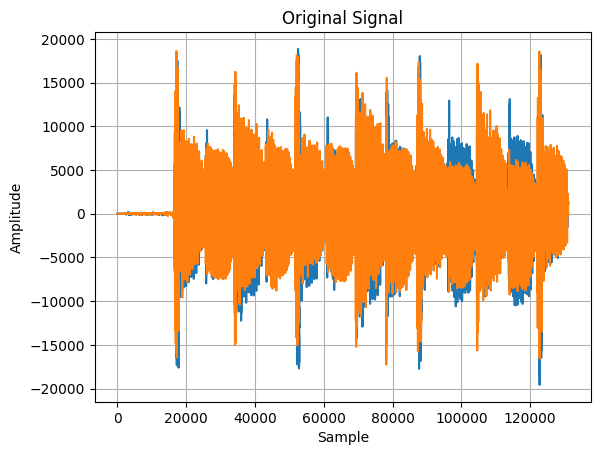

In [25]:
sd.play(x)
plot(np.linspace(0, len(x)-1, len(x)), x, "Sample", "Amplitude", "Original Signal")

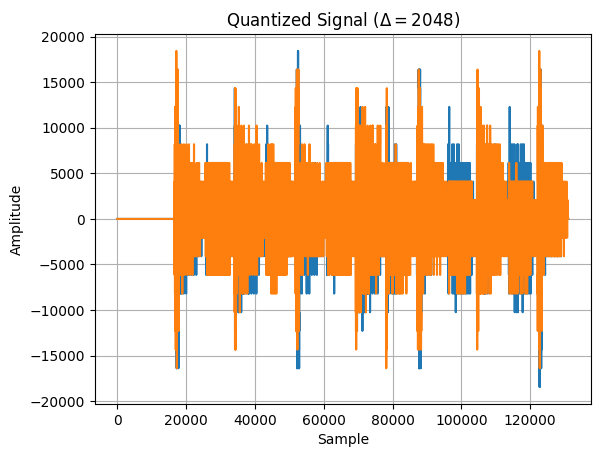

In [26]:
quantization_step = 2048
k, y = q_deq(x, quantization_step)
sd.play(y)
plot(np.linspace(0, len(y)-1, len(y)), y, "Sample", "Amplitude", "Quantized Signal ($\Delta={}$)".format(quantization_step))

In [27]:
def average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(average_energy(error_signal))

def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

def RD_curve(x):
    points = []
    for q_step in range(128, 4096, 128):
        k, y = q_deq(x, q_step)
        #print(np.unique(k))
        rate = entropy_in_bits_per_symbol(k)
        distortion = RMSE(x, y)
        points.append((rate, distortion))
    return points

In [28]:
RD_points = RD_curve(x)

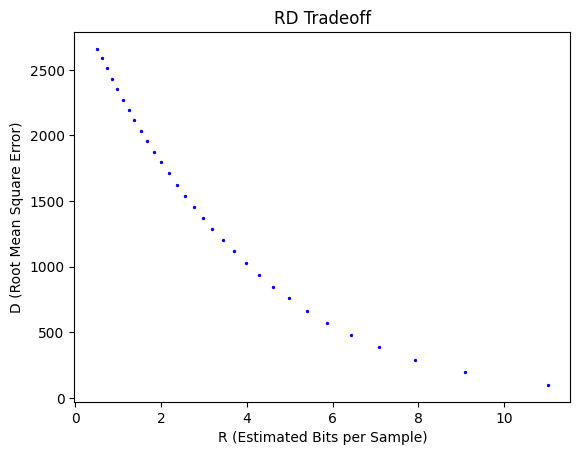

In [30]:
plt.title("RD Tradeoff")
plt.xlabel("R (Estimated Bits per Sample)")
plt.ylabel("D (Root Mean Square Error)")
plt.scatter(*zip(*RD_points), s=2, c='b', marker="o")
plt.show()

### Let's listen to the effect of a bit-rate control algorithm

The quantizer is controlled by the following algorithm:

1. Every second (by default) run:
  \begin{equation}
    \left\{
    \begin{array}{ll}
      \Delta = 2\Delta & \quad\text{if}~L>2 \\
      \Delta = \frac{10}{11}\Delta & \quad\text{always}.
    \end{array}
    \right.
  \end{equation}
 where $L$ is the number of lost chunks in the previus "bit-rate control period" of time.

In [32]:
# (only Linux)

avg_latency = 10
mean_deviation = 10
correlation = 50
distribution = "normal"
throughput = 300 # KBPS

!sudo tc qdisc add dev lo root handle 1: netem delay {avg_latency}ms {mean_deviation}ms {correlation}% distribution {distribution}
!sudo tc qdisc add dev lo parent 1:1 handle 10: tbf rate {throughput}kbit burst 64kbit limit 64kbit

!python ../src/BR_control_conservative.py --show_stats -t 20 -f ../data/AviadorDro_LaZonaFantasma.oga

!sudo tc qdisc del dev lo parent 1:1 handle 10:
!sudo tc qdisc del dev lo root
!tc qdisc show dev lo

(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7
(INFO) buffer: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) DEFLATE_raw: Compress each raw chunk using DEFLATE.
(INFO) DEFLATE_byteplanes3: Compress the least significant byte planes of the chunks using DEFLATE. The channels are consecutive (serialized). 3 code-streams (one per byte-plane) are generated.
(INFO) BR_control_no: No bit-rat

### Some conclusions:

1. The transmission should have a smaller number of lost chunks compared to not using BR-control.
2. Probably some extra technique should be applied to have a larger "useful" range of the quantization step size.

## 5. [Removing intra-frame (inter-channel or spatial) redundancy](https://tecnologias-multimedia.github.io/study_guide/transform_coding/#x1-30001.1)

* Transform Coding increases the dynamic range of the coefficients and therefore, the "useful" range of the quantization step size.

### The MST (Mid/Side Transform)
The samples of a (stereo) frame tend to have similar amplitudes. For this reason, we apply [Mid/Side stereo coding](https://en.wikipedia.org/wiki/Joint_encoding#M/S_stereo_coding) (before quantization).

* The MST (Mid/Side Transform) analysis transform
\begin{equation}
  \mathbf{w} = \mathbf{K}\mathbf{x} = \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}\mathbf{x},
  \label{eq:forward_transform_matrix_form}
\end{equation}
that can be also written as
\begin{equation}
  \begin{bmatrix}
    \mathbf{w}_0 \\
    \mathbf{w}_1
  \end{bmatrix}
  = 
  \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
  \begin{bmatrix}
    \mathbf{x}_0 \\
    \mathbf{x}_1
  \end{bmatrix}, \tag{1}
\end{equation}
where $\mathbf{x}$ is a stereo frame, $\mathbf{K}$ is the (forward or analysis)
transform matrix, and $\mathbf{w}=\begin{bmatrix} \mathbf{w}_0 & \mathbf{w}_1\end{bmatrix}^{\text
  T}$ is the corresponding [decomposition](https://en.wikipedia.org/wiki/Discrete_wavelet_transform#Example_in_image_processing).
  
* The synthesis transform defined by
\begin{equation}
  \mathbf{x} = \mathbf{K}^{-1}\mathbf{w}
  \label{eq:inverse_transform}
\end{equation}
can be found from Eq. (1), where we
get that
\begin{equation}
  \begin{array}{rcl}
  \mathbf{w}_0 & = & \mathbf{x}_0 + \mathbf{x}_1\\
  \mathbf{w}_1 & = & \mathbf{x}_0 - \mathbf{x}_1.
  \end{array}
\end{equation}
By solving $\mathbf{x}_0$ (adding) and $\mathbf{x}_1$ (substracting) in
these equations, we obtain that
\begin{equation}
  \begin{array}{rcl}
  \mathbf{x}_0 & = & \frac{1}{2}(\mathbf{w}_0 + \mathbf{w}_1)\\
  \mathbf{x}_1 & = & \frac{1}{2}(\mathbf{w}_0 - \mathbf{w}_1),
  \end{array}
\end{equation}
that in matrix form becomes
\begin{equation}
  \begin{bmatrix}
    \mathbf{x}_0 \\
    \mathbf{x}_1
  \end{bmatrix}
  = \frac{1}{2}
  \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
  \begin{bmatrix}
    \mathbf{w}_0 \\
    \mathbf{w}_1
  \end{bmatrix}.
\end{equation}

Therefore,
\begin{equation}
  \mathbf{x} = \mathbf{K}^{-1}\mathbf{w} = \frac{1}{2}\mathbf{K}^{\text T}\mathbf{w} = \frac{1}{2}\mathbf{K}\mathbf{w} = \frac{1}{2}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}\mathbf{w}.
  \label{eq:inverse_transform_matrix_form}
\end{equation}

In [33]:
def plot(y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    x = np.linspace(0, len(y)-1, len(y))
    ax.plot(x, y, '.', markersize=1)
    plt.show(block=False)

In [34]:
# Run this cell if you have a mic
fs = 44100      # Sampling frequency
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=2, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")

Say something!
done


In [36]:
# Run this cell if you don't have a mic
import soundfile
x, sampling_rate = soundfile.read("../data/AviadorDro_LaZonaFantasma.oga")
x = x[0:65536*2] * 32768
x = x.astype(np.int16)

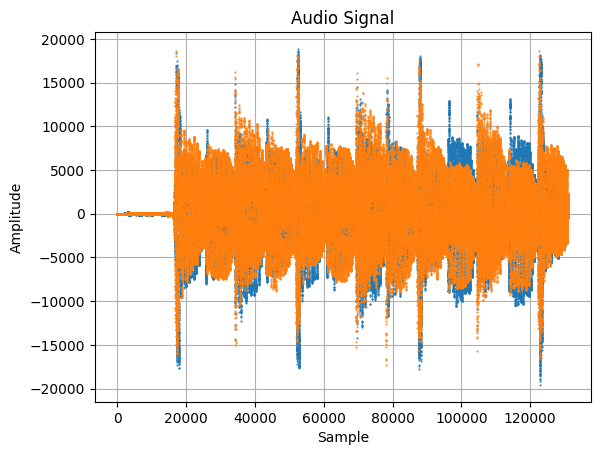

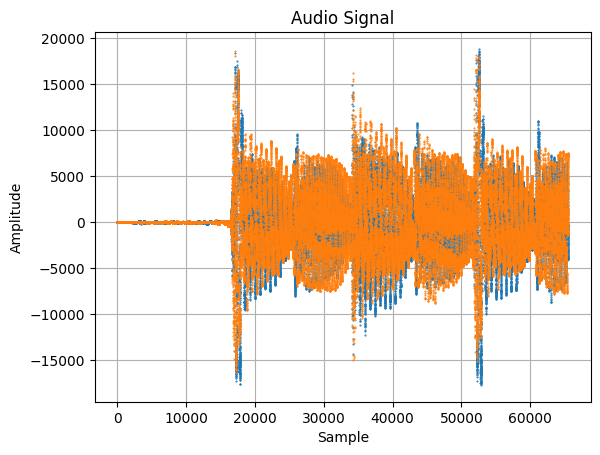

In [37]:
plot(x, "Sample", "Amplitude", "Audio Signal")
#x = x[65536:]
x = x[:65536] # The Dyadic DWT works better when the number of samples is a power of 2
plot(x, "Sample", "Amplitude", "Audio Signal (zoom)")
sd.play(x)

In [38]:
def MST_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = x[:, 0].astype(np.int32) + x[:, 1] # L(ow frequency subband)
    w[:, 1] = x[:, 0].astype(np.int32) - x[:, 1] # H(igh frequency subband)
    return w

def MST_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = (w[:, 0] + w[:, 1])/2 # L(ow frequency subband)
    x[:, 1] = (w[:, 0] - w[:, 1])/2 # H(igh frequency subband)
    return x

In [39]:
w = MST_analyze(x)

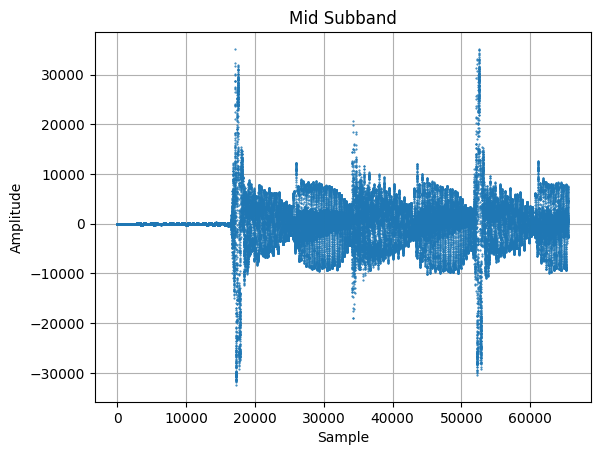

In [44]:
plot(w[:, 0], "Sample", "Amplitude", "Mid Subband")
sd.play(w[:, 0].astype(np.int16))

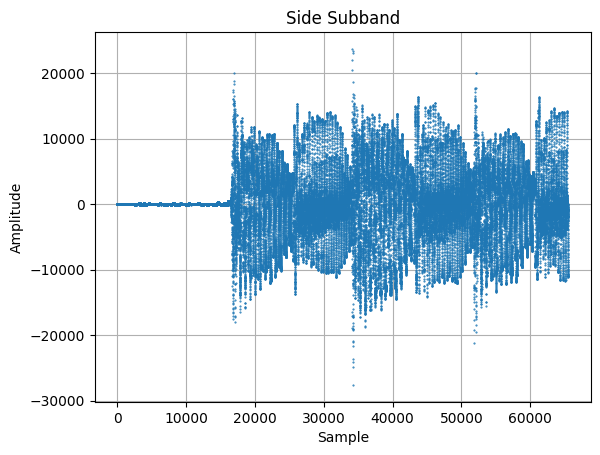

In [45]:
plot(w[:, 1], "Sample", "Amplitude", "Side Subband")
sd.play(w[:, 1].astype(np.int16))

In [42]:
K1 = np.array([1.0, 1.0])
w1, h1 = signal.freqz(K1, fs=44100)
K2 = np.array([1.0, -1.0])
w2, h2 = signal.freqz(K2, fs=44100)

/tmp/ipykernel_4615/1969458427.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w2, 20 * np.log10(abs(h2)), 'b')


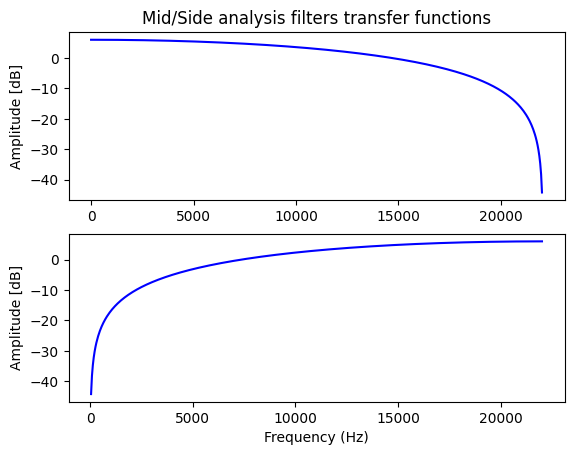

In [43]:
plt.subplot(211)
plt.title('Mid/Side analysis filters transfer functions')
plt.plot(w1, 20 * np.log10(abs(h1)), 'b')
plt.ylabel('Amplitude [dB]')
plt.subplot(212)
plt.plot(w2, 20 * np.log10(abs(h2)), 'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.show()

* Notice that both filters have the same gain, although with only 2 taps, the filtering performance is not very high (we are able to recognize the audio in both subbands) :-/

### Quantization of the MST subbands

In [46]:
def quantizer(x, quantization_step):
    '''Deadzone quantization.'''
    k = (x / quantization_step).astype(np.int32)
    return k

def q_RD_curve(data):
    '''RD curve in the space domain.'''
    RD_points = []
    for q_step in range(16, 1024, 32):
        k, y = q_deq(data, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        distortion = RMSE(data, y)
        RD_points.append((rate, distortion))
    return RD_points

def MST_RD_curve(data):
    '''RD curve in the MST domain.'''
    RD_points = []
    for q_step in range(16, 1024, 32):
        analyzed_data = MST_analyze(data)
        k, y = q_deq(analyzed_data, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        reconstructed_data = MST_synthesize(y)
        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    return RD_points

In [47]:
q_RD_points = q_RD_curve(x)
MST_RD_points = MST_RD_curve(x)

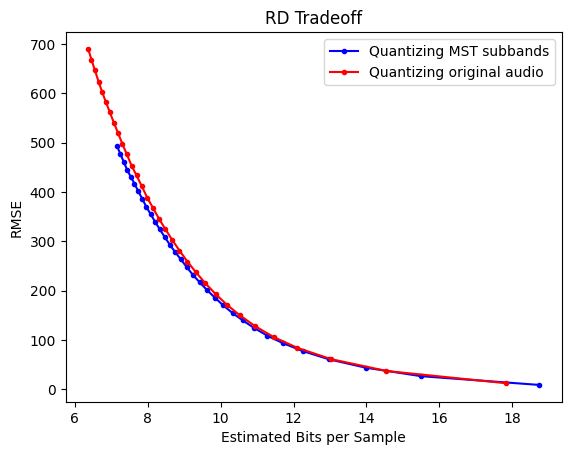

In [48]:
plt.title("RD Tradeoff")
plt.xlabel("Estimated Bits per Sample")
plt.ylabel("RMSE")
plt.plot(*zip(*MST_RD_points), c='b', marker=".", label='Quantizing MST subbands')
plt.plot(*zip(*q_RD_points), c='r', marker=".", label='Quantizing original audio')
plt.legend(loc='upper right')
plt.show()

### Conclusions

1. As it can be seen, the distortion is an exponential function (with a negative exponent). This basically implies that when the bit-rate decreases ($\Delta$ increases), the distortion also increases exponentially. Therefore, when we have two (or more) signals that are quantized, it is more beneficial from the a RD point of view, to increase $\Delta$ by $x/2$ in both subbands, than $x$ in only one of them.

2. Notice that the quantization pattern $\Delta_0==\Delta_1$ is only a heuristic that works fine in most of situations, and that generates the same amount of distortion in the amplitude of the audio signal and the stereo information. To determine the optimal value of the QSSs, we should always solve for the option that is the most beneficial, based on the real RD curve.

3. Since both subbands ($\mathbf{w}_0$ and $\mathbf{w}_1$) have the same gain, and in general, the quantization error is independent of the signal (for low enough $\Delta$ values), in theory the quantization pattern $\Delta_0==\Delta_1$ should yield an acceptable RD performance, because we are generating the same amount of quantization error in both subbands, for a given bit-rate.

4. You can get more insights about the optimal quantization in the MST domain in his [notebook](https://github.com/Tecnologias-multimedia/Tecnologias-multimedia.github.io/blob/master/contents/transform_coding/stereo_transforms_RD.ipynb).

### Result of aplying the MST to InterCom

In [49]:
# Real machine
!python ../src/stereo_MST_coding_16.py --show_stats -t 20 -f ../data/AviadorDro_LaZonaFantasma.oga

(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7
(INFO) buffer: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) DEFLATE_raw: Compress each raw chunk using DEFLATE.
(INFO) DEFLATE_byteplanes3: Compress the least significant byte planes of the chunks using DEFLATE. The channels are consecutive (serialized). 3 code-streams (one per byte-plane) are generated.
(INFO) BR_control_no: No bit-rat

In [ ]:
# Virtual machine
!python ../src/stereo_MST_coding_16.py --show_stats -s 8000 -t 20 -f ../data/AviadorDro_LaZonaFantasma_8000Hz.oga --frames_per_chunk 256

## 6. [Removing intra-channel (inter-frame or temporal) redundancy](https://tecnologias-multimedia.github.io/contents/transform_coding/#x1-80001.2)

* The samples of each channel exhibit temporal redundancy. Therefore, we use a [dyadic](https://en.wikipedia.org/wiki/Discrete_wavelet_transform) [Discrete Wavelet Transform (DWT)](https://tecnologias-multimedia.github.io/contents/transform_coding//#x1-80001.2) to exploit it (before quantization).
* See [here](https://cseweb.ucsd.edu/classes/fa17/cse166-a/lec13.pdf) some Wavelet functions.

### [Implementation of the DWT with Perfect Reconstruction Filter Banks](https://tecnologias-multimedia.github.io/study_guide/transform_coding/#x1-80001.2)

* The DWT can be implemented as a cascade of 2-channels PRFBs:
$~$
![DWT](https://tecnologias-multimedia.github.io/contents/transform_coding/graphics/cascade.svg)
$$~$$
where $\mathbf{l}$ stands for low-frequency subband, and $\mathbf{h}$ for high-frequency subband. $\downarrow 2$ represents a decimation where one of each two samples is ignored, and $\uparrow 2$ the insertion of a 0 where the decimator discarded a sample.

* Depending on how
$\phi$ (the **analysis scaling function** (low-pass frequency analysis filter)),
$\psi$ (the **analysis wavelet function** (high-pass frequency analysis filter),
$\tilde\phi$ (the **synthesis scaling function** (low-pass frequency synthesis filter),
and $\tilde\psi$ the **synthesis wavelet function** (high-pass frequency synthesis filter))
are defined, a different DWT is computed.

### [Implementation of the DWT with Lifting](https://tecnologias-multimedia.github.io/study_guide/transform_coding/#x1-80001.2)

Allows to avoid the use of the decimators, dividing by 2 the number of operations.

#####  Example with linear interpolation:

\begin{equation}
  {\mathbf h}^l_i = {\mathbf l}^{l-1}_{2i+1} - \frac{1}{2}({\mathbf l}^{l-1}_{2i} + {\mathbf l}^{l-1}_{2i+2})
\end{equation}
\begin{equation}
  {\mathbf l}^l_i = {\mathbf l}^{l-1}_{2i} + \frac{1}{4}({\mathbf h}^l_{i-1} + {\mathbf h}^l_i),
\end{equation}

### Spectral resolution provided by the dyadic DWT

* The DWT generates the dyadic decomposition (for $2^l$ samples, where $l$ is the number of levels of the DWT):
 \begin{equation*}
    | \mathbf{l}^s_0 | \mathbf{h}^s_0 | \mathbf{h}^{s-1}_0 \mathbf{h}^{s-1}_1 | \mathbf{h}^{s-2}_0 \mathbf{h}^{s-2}_1 \mathbf{h}^{s-2}_2 \mathbf{h}^{s-2}_3 | \cdots | \mathbf{h}^1_0 \mathbf{h}^1_1 \cdots \mathbf{h}^1_{2^{n-1}-1} |,
  \end{equation*}
where $s$ represents the subband index ($s$), and each subband contains a set of
coefficients (distinguished by subscript).

* It holds that:
\begin{equation}
  W({\mathbf h}^s) = \frac{1}{2}W({\mathbf h}^{s-1}),
\end{equation}
and that:
\begin{equation}
  W({\mathbf l}^{N_{\text{levels}}}) = W({\mathbf h}^{N_{\text{levels}}}),
\end{equation}
being $W(\cdot)$ the bandwidth of the corresponding
subband $s$.

### A real example:

In [50]:
def average_complex_energy(x):
    return np.sum(x.real.astype(np.double)*x.real.astype(np.double) +
                  x.imag.astype(np.double)*x.imag.astype(np.double))/len(x)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

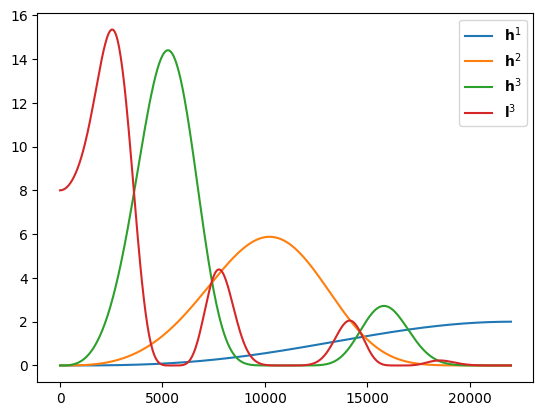

In [51]:
import pywt # pip install pywavelets
from IPython.display import Math

%matplotlib inline

#filters_name = "haar"
filters_name = "db5"
#filters_name = "db7"
#filters_name = "db11"
#filters_name = "db20"
filters_name = "bior3.5"

wavelet = pywt.Wavelet(filters_name)

N_levels = 3

for l in range(N_levels):
    filters = wavelet.wavefun(level = (l+1))[:-1]
    w0, h0 = signal.freqz(filters[0], fs=44100)
    w1, h1 = signal.freqz(filters[1], fs=44100)
    plt.plot(w1, abs(h1), label="$\\mathbf{h}$" + f"$^{l+1}$")
    display(Math("\\text{Average energy of}~" + "\mathbf{h}" + f"^{l+1}" + f" = {average_complex_energy(h1)}"))
plt.plot(w0, abs(h0), label="$\\mathbf{l}$" + f"$^{l+1}$")
display(Math("\\text{Average energy of}~" + "\mathbf{l}" + f"^{l+1}" + f" = {average_complex_energy(h0)}"))
plt.legend(loc="best")
plt.show()

### Quantization in the (Dyadic) DWT domain

* As it can be seen, if the DWT is orthogonal, then
\begin{equation}
  |(\mathbf{h}^s)|^2 = \frac{1}{2}|\mathbf{h}^{s-1}|^2,
\end{equation}
and
\begin{equation}
  |\mathbf{l}^s|^2 = |\mathbf{h}^s|^2,
\end{equation}
where $|\cdot|^2$ is the L$^2$ energy of the corresponding subband. Therefore
(considering also the bandwidth of each subband), it holds that all the subbands
have the same gain.

* This is the same situation as in the MST (but now with more subbands). For this reason,
all the DWT coefficients are quantized using the same $\Delta$. You can get extra
information in this [notebook](https://github.com/Tecnologias-multimedia/Tecnologias-multimedia.github.io/blob/master/contents/transform_coding/DWT_RD.ipynb).

### (Dyadic) DWT in action (only Linux)
Go to the shell and run:
```
python ../test/sounddevice/plot_input_stereo.py &
python ../test/transforms/rfft_hamming.py &
python ../test/transforms/dwt5.py &
python ../test/sounddevice/play_sine.py 440
```

### DWT RD performance

In [52]:
def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int32)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

def DWT_analyze(x, levels):
    coefs = np.empty(x.shape, dtype=np.int32)
    decomposition_0 = pywt.wavedec(x[:, 0], wavelet=wavelet, level=levels, mode="per")
    decomposition_1 = pywt.wavedec(x[:, 1], wavelet=wavelet, level=levels, mode="per")
    coefs_0, slices = pywt.coeffs_to_array(decomposition_0)
    coefs_1, slices = pywt.coeffs_to_array(decomposition_1)
    coefs[:, 0] = np.rint(coefs_0).astype(np.int32)
    coefs[:, 1] = np.rint(coefs_1).astype(np.int32)
    return coefs, slices

def DWT_synthesize(coefs, slices):
    samples = np.empty(coefs.shape, dtype=np.int32)
    decomposition_0 = pywt.array_to_coeffs(coefs[:, 0], slices, output_format="wavedec")
    decomposition_1 = pywt.array_to_coeffs(coefs[:, 1], slices, output_format="wavedec")
    samples[:, 0] = np.rint(pywt.waverec(decomposition_0, wavelet=wavelet, mode="per")).astype(np.int32)
    samples[:, 1] = np.rint(pywt.waverec(decomposition_1, wavelet=wavelet, mode="per")).astype(np.int32)
    return samples

def DWT_RD_curve(data, levels):
    RD_points = []
    for q_step in range(16, 1024, 32):
        MST_coefs = MST_analyze(data)
        DWT_coefs, slices = DWT_analyze(MST_coefs, levels)
        k, y = q_deq(DWT_coefs, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        MST_coefs = DWT_synthesize(y, slices)
        reconstructed_data = MST_synthesize(MST_coefs)
        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    return RD_points

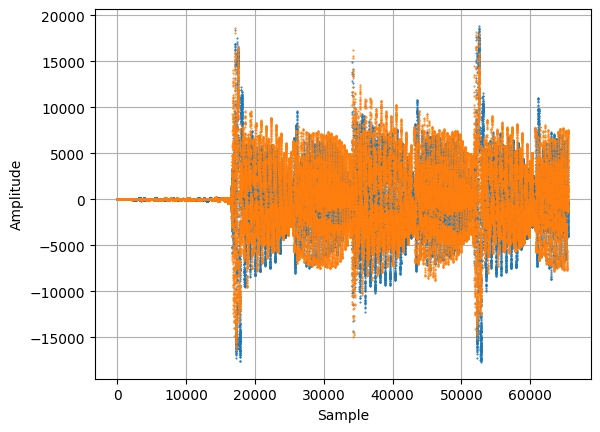

In [53]:
x = x[:65536]
plot(x, "Sample", "Amplitude", "")
sd.play(x.astype(np.int16))

In [54]:
q_RD_points = q_RD_curve(x)
MST_RD_points = MST_RD_curve(x)
DWT_RD_points = DWT_RD_curve(x, levels = N_levels)

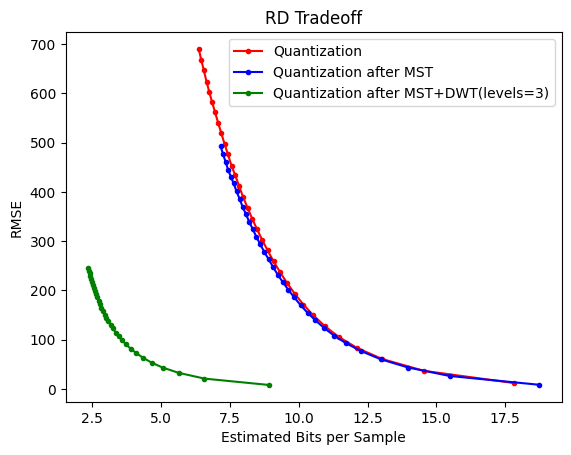

In [55]:
plt.title("RD Tradeoff")
plt.xlabel("Estimated Bits per Sample")
plt.ylabel("RMSE")
plt.plot(*zip(*q_RD_points), c='r', marker=".", label='Quantization')
plt.plot(*zip(*MST_RD_points), c='b', marker=".", label='Quantization after MST')
plt.plot(*zip(*DWT_RD_points), c='g', marker=".", label=f'Quantization after MST+DWT(levels={N_levels})')
plt.legend(loc='upper right')
plt.show()

### [Overlapped processing]()

#### The problem
![3 chunks](https://tecnologias-multimedia.github.io/contents/transform_coding/3_chunks.svg)
![original reconstruction](https://tecnologias-multimedia.github.io/contents/transform_coding/without.svg)
![extended](https://tecnologias-multimedia.github.io/contents/transform_coding/extended.svg)
![improved reconstruction](https://tecnologias-multimedia.github.io/contents/transform_coding/reconstructed.svg)

#### A solution
![Overlapping betweem chunks](https://tecnologias-multimedia.github.io/contents/transform_coding/graphics/overlapping.svg)

### Result of applying the DWT to InterCom

In [ ]:
!python ../src/temporal_overlapped_DWT_coding.py --show_stats -t 20 -f ../data/AviadorDro_LaZonaFantasma.oga

## 7. [Perceptual]((https://en.wikipedia.org/wiki/Psychoacoustics)) Coding

### Frequency resolution provided by the (Dyadic) DWT vs the [Threshold of (Human) Hearing (ToH)](https://tecnologias-multimedia.github.io/study_guide/threshold_of_hearing/)

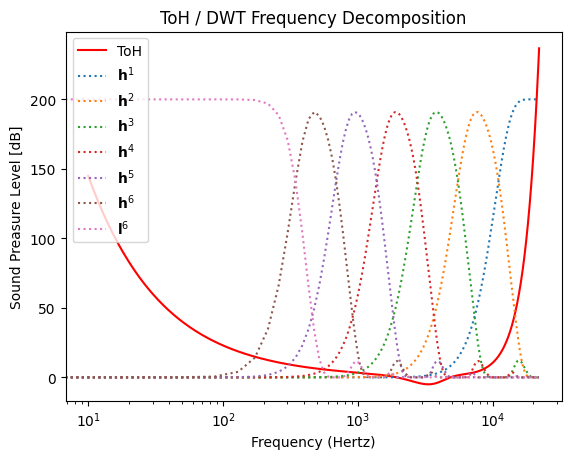

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pywt
from scipy import signal

x = np.linspace(10,22050,22050)
y = 3.64*(x/1000)**(-0.8) - 6.5*np.exp((-0.6)*(x/1000-3.3)**2) + 1E-3*(x/1000)**4
plt.xscale("log")
plt.yscale("linear")
plt.title("ToH / DWT Frequency Decomposition")
plt.xlabel("Frequency (Hertz)")
plt.ylabel("Sound Preasure Level [dB]")
plt.plot(x, y, c='r', label="ToH")

wavelet = pywt.Wavelet("db5")

N_levels = 6

for l in range(N_levels):
    filters = wavelet.wavefun(level = (l+1))[:-1]
    w0, h0 = signal.freqz(filters[0], fs=44100)
    w1, h1 = signal.freqz(filters[1], fs=44100)
    plt.plot(w1, 100*abs(h1)/2**l, label="$\\mathbf{h}$" + f"$^{l+1}$", linestyle="dotted")
plt.plot(w0, 100*abs(h0)/2**(N_levels-1), label="$\\mathbf{l}$" + f"$^{l+1}$", linestyle="dotted")

plt.legend(loc='best')

plt.show()

* The QSSs are adapted to the ToH in each DWT subband.

### Result of applying the ToH to InterCom

In [56]:
!python ../src/basic_ToH.py -q 512 --show_stats -t 20 -f ../data/AviadorDro_LaZonaFantasma.oga

(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7
(INFO) buffer: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) DEFLATE_raw: Compress each raw chunk using DEFLATE.
(INFO) DEFLATE_byteplanes3: Compress the least significant byte planes of the chunks using DEFLATE. The channels are consecutive (serialized). 3 code-streams (one per byte-plane) are generated.
(INFO) BR_control_no: No bit-rat

## 8. Future work
1. Use the [DCT (Discrete Cosine Transform)](https://en.wikipedia.org/wiki/Discrete_cosine_transform) to increase the frequency accuracy in each DWT subband.
2. Consider the [masking effects](https://en.wikipedia.org/wiki/Auditory_masking).
3. [Echo cancellation](https://en.wikipedia.org/wiki/Echo_suppression_and_cancellation).
4. [Video](https://en.wikipedia.org/wiki/Video)!

## Appendix

### Resumen

La transmisión en tiempo real de señales sobre redes de datos no dedicadas plantea problemas de latencia y de rendimiento. En este seminario se analizan las principales técnicas usadas para mitigar dichos problemas, y se evalúa su efectividad en InterCom (https://github.com/Tecnologias-multimedia/InterCom), una aplicación que permite la intercomunicación (mediante señales de audio) entre 2 usuarios conectados a Internet. Más información en https://github.com/Tecnologias-multimedia/InterCom/blob/master/docs/2-hours_seminar.ipynb.

The real-time transmission of signals over non-dedicated data networks generates latency and performance issues. In this seminar, the main techniques used to mitigate these problems are analyzed, and their effectiveness is evaluated in InterCom (https://github.com/Tecnologias-multimedia/InterCom), an application that allows intercommunication (through audio signals) between 2 users connected to the Internet. More information at https://github.com/Tecnologias-multimedia/InterCom/blob/master/docs/2-hours_seminar.ipynb.